# Planar Si solar cell using PDD

In the previous example, we looked at a silicon cell using the depletion approximation. Here, we will instead use one of Solcore's Poisson drift-diffusion (PDD) solvers, which can handle doping profiles (not just constant doping levels). Note that Solcore actually has two PDD solvers: a built-in one which was developed in Fortran specifically for cells with quantum wells, and an interface to the [Sesame](https://pages.nist.gov/sesame/) package, which was written in Python and developed for silicon-based cells. Here, we will use the Sesame solver. 

The script starts of in much the same way as the DA cell in the previous example: we import relevant external packages and Solcore features, define some of the materials we will use, and set user options for ``solar_cell_solver``.

In [1]:
from solcore.solar_cell import SolarCell, Junction, Layer
from solcore.state import State
from solcore.solar_cell_solver import solar_cell_solver
import numpy as np
from solcore.light_source import LightSource
from scipy.special import erfc

import matplotlib.pyplot as plt

from solcore import material, si

MgF2 = material("MgF2")()
Ag = material("Ag")()
TCO = material('ITO2')()

wavelengths = np.linspace(280, 1200, 100)*1e-9

options = State() # initialise the options
options.wavelength = wavelengths
options.optics_method = 'TMM'
options.light_iv = True
options.T = 298
options.light_source = LightSource(source_type="standard",
                           version="AM1.5g", x=options.wavelength)

options.voltages = np.linspace(0, 0.8, 40)
options.internal_voltages = options.voltages
options.mpp = True
options.no_back_reflection = False
options.position = 1e-9

/Users/z3533914/.pyenv/versions/3.11.5/lib/python3.11/site-packages/solcore/registries.py:73: UserWarning: Optics solver 'RCWA' will not be available. An installation of S4 has not been found.
  warn(


## Defining materials and doping profile

The Sesame PDD solver which we will be using can accept depth-dependent doping profiles (although you can also still set constant doping, like in the previous example, for each layer). Because we are going to pass a doping profile rather than distinct p
and n-type materials, we just define one Si material which will be used for the whole junction, with electron and hole mobilities and lifetimes.

Of course, there are many other material parameters which the PDD solver must have access to, such as radiative and Auger recombination rates, electron affinity, etc.; these are stored in Solcore's material database, but they can always be overridden by user-specified values when calling the ``material`` function.

In [2]:
Si_pn = material("Si")(electron_mobility=si("1e4cm2"), hole_mobility=si("1e3cm2"),
                       electron_minority_lifetime=0.001, hole_minority_lifetime=0.001)

Now we will define the doping profile. We will define a p-n junction, with the highly-doped region (the emitter) at the rear and an complimentary error function ('erfc') profile at the front and rear surfaces. Note that Solcore expects the doping to be provided in base Si units (per m3). Solcore expects the doping profile information in the form of a function which returns the doping at a given depth (in m) in the junction. Positive values are n-type doping, negative values are p-type.

In [3]:
nD = si("1e20cm-3") # maximum n-type (donor) doping
nA = si("1e19cm-3") # maximum p-type (acceptor) doping
bulk_doping = si("5e15cm-3") # n type bulk doping

d_bulk = 100e-6 # Si thickness, in m

# rear junction (n-type)
def doping_profile_func(x):

    L = d_bulk

    doping_profile = - nA * erfc(x/300e-9) # characteristic depth of 300 nm - front p-type doping

    doping_profile_rear = nD * erfc((L - x)/200e-9) # characteristic depth of 200 nm - rear n-type doping

    return doping_profile + doping_profile_rear + bulk_doping

To check it looks reasonable, let's plot this doping profile:

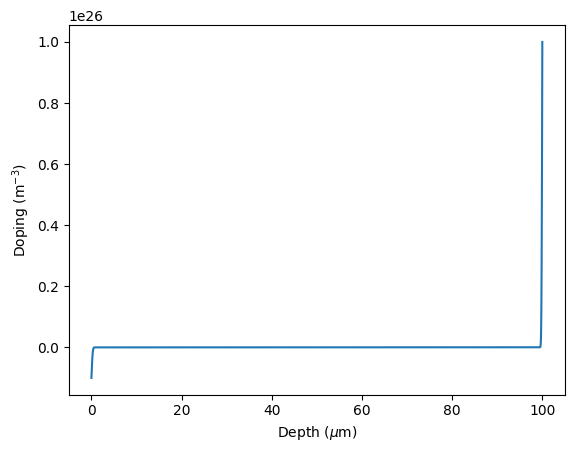

In [4]:
depth = np.linspace(0, d_bulk, int(1e5))

plt.figure()
plt.plot(depth*1e6, doping_profile_func(depth))
plt.xlabel(r"Depth ($\mu$m)")
plt.ylabel(r"Doping (m$^{-3}$)")
plt.show()

That didn't help very much, because the cell is too wide compared to the region where the doping is changing! Let's try again but splitting the plot into two parts for the front and rear surface (since nothing interesting is happening in the middle).

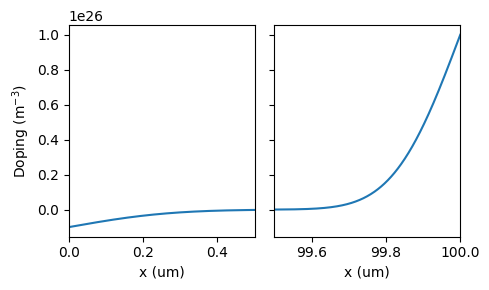

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(5, 3))

ax1.plot(depth*1e6, doping_profile_func(depth))
ax1.set_xlim(0, 0.5)
ax1.set_ylabel(r"Doping (m$^{-3}$)")
ax1.set_xlabel('x (um)')

ax2.plot(depth*1e6, doping_profile_func(depth))
ax2.set_xlim(d_bulk*1e6 - 0.5, d_bulk*1e6)
ax2.set_xlabel('x (um)')
plt.tight_layout()
plt.show()

We will add transparent conducting oxides (TCOs) and an anti-reflection coating. Note that a real Si cell would have a more complicated layer structure (for example, for a heterojunction cell, the amorphous Si layers); we can add as many layers as we want for Solcore to consider, but will keep it simple here. In this case, these layers will be outside the junction: this means they will have optical effects but will not be included in the drift-diffusion calculation. They can be included in the junction, but this requires setting the relevant carrier transport-related parameters.

In [6]:
front_materials = [Layer(80e-9, MgF2), Layer(55e-9, TCO)]

back_materials = [Layer(55e-9, TCO), Layer(120e-9, MgF2)]

## Defining the junction and the cell

Another important cell parameter, for both the depletion approximation and the drift-diffusion solvers, is the surface recombination. This is passed to Solcore as a surface recombination velocity (SRV). With the `Si_pn` material, the doping profile function, and the SRVs, we define the Junction. We set the `kind` of junction to `sesame_PDD`, so that Solcore knows to use the Sesame PDD solver.

In [7]:
Si_junction = [Junction([Layer(d_bulk, Si_pn)],
                        doping_profile=doping_profile_func, kind='sesame_PDD',
                        sn=2, sp=1, # SRVs. Note these should be in m/s, not cm/s! sn refers to the n-type region (can be at the back or the front!), sp to the p-type.
                        )]

Now we combine the surface layers and the junction into a solar cell, with 2% shading and a silver back mirror.

In [9]:
Si_cell = SolarCell(front_materials +  Si_junction + back_materials,
                    shading=0.02,
                    substrate=Ag,
                    )

## Calculating the IV and QE

Now we ask Solcore to solve both the light IV and QE of the cell:

In [10]:
solar_cell_solver(Si_cell, 'qe', options)
solar_cell_solver(Si_cell, 'iv', options)

Treating layer(s) 2 incoherently
Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


Now we plot the results. Here we have multiple layers, and the junction is actually the third element in the solar cell, so we could access its properties by typing ``Si_cell[2]`` (since Python starts counting at 0). However, Solcore has a built-in way to find only the junctions (so, the electrically active) parts of the cell: ``Si_cell(0)`` will automatically find the first junction. Similarly, ``Si_cell(1)`` would give us the second junction, etc. This avoids having to manually count layers to find out which ones are the Junctions.

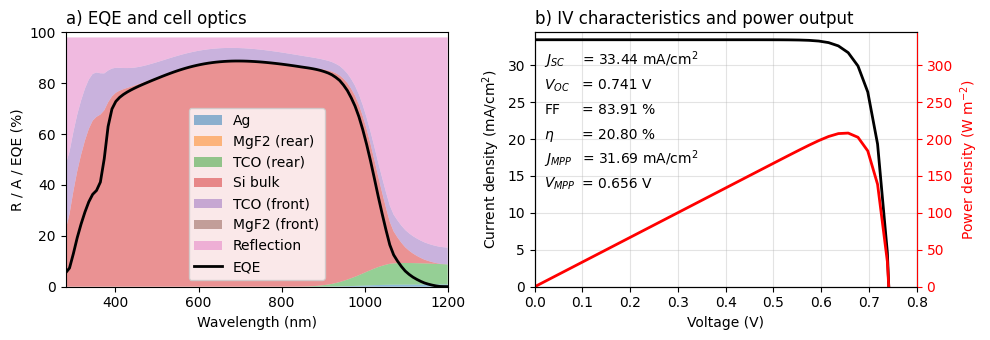

In [12]:
result_stack = np.vstack([Si_cell.reflected, [layer.layer_absorption for layer in Si_cell], Si_cell.transmitted])

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))
ax.stackplot(wavelengths * 1e9, 100 * result_stack[::-1], linewidth=0.5, alpha=0.5,
             labels=['Ag', 'MgF2 (rear)', 'TCO (rear)', 'Si bulk', 'TCO (front)', 'MgF2 (front)',
                     'Reflection'])
ax.plot(wavelengths * 1e9, 100 * Si_cell(0).eqe(wavelengths), '-k', linewidth=2,
        label='EQE')

ax.set_xlim(280, 1200)
ax.set_ylim(0, 100)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("R / A / EQE (%)")
ax.set_title('a) EQE and cell optics', loc='left')
ax.legend()

jsc = Si_cell.iv.Isc / 10

ax2.plot(Si_cell.iv['IV'][0], Si_cell.iv['IV'][1] / 10, '-', label='IV',
         linewidth=2, color='k')

ax2.set_ylim(0, 1.03 * jsc)
ax2.set_xlim(np.min(options.voltages), np.max(options.voltages))
ax2.set_xlabel('Voltage (V)')
ax2.set_ylabel('Current density (mA/cm$^2$)')
ax2.set_title('b) IV characteristics and power output', loc='left')

ax3 = ax2.twinx()
ax3.plot(options.voltages, Si_cell.iv['IV'][0] * Si_cell.iv['IV'][1],
         '-r', label='Power', linewidth=2)
ax3.set_ylabel('Power density (W m$^{-2}$)')
ax3.set_ylim(0, 1.03 * jsc * 10)

# change colour of right-hand axis to red
ax3.spines['right'].set_color('r')
ax3.yaxis.label.set_color('r')
ax3.tick_params(axis='y', colors='r')

# Everything here is to add text to the right-hand plot:

ax2.text(0.02, 0.9 * jsc, r'$J_{SC}$', zorder=5)
ax2.text(0.02, 0.8 * jsc, r'$V_{OC}$')
ax2.text(0.02, 0.7 * jsc, 'FF')
ax2.text(0.02, 0.6 * jsc, r'$\eta$')
ax2.text(0.02, 0.5 * jsc, r'$J_{MPP}$')
ax2.text(0.02, 0.4 * jsc, r'$V_{MPP}$')

ax2.text(0.1, 0.9 * jsc, r'= {:.2f} mA/cm$^2$'.format(jsc))
ax2.text(0.1, 0.8 * jsc, r'= {:.3f} V'.format(Si_cell.iv.Voc))
ax2.text(0.1, 0.7 * jsc, '= {:.2f} %'.format(Si_cell.iv.FF * 100))
ax2.text(0.1, 0.6 * jsc, r'= {:.2f} %'.format(Si_cell.iv.Eta * 100))
ax2.text(0.1, 0.5 * jsc, r'= {:.2f} mA/cm$^2$'.format( Si_cell.iv.Impp / 10))
ax2.text(0.1, 0.4 * jsc, r'= {:.3f} V'.format(Si_cell.iv.Vmpp))
ax2.grid(which='major', alpha=0.35)

ax3.grid(False)
plt.tight_layout()

plt.show()

Since this is a planar cell (i.e. no pyramids or other textured surface to reduce reflectance and increase the path length inside the cell), we see high losses due to reflection. We also see parasitic absorption in the front and rear TCO. 

## Auger-limited cell

Recently, record-efficiency silicon cells have been optimized to such a level that Auger recombination (rather than Shockley-Read-Hall recombination) becomes the dominant recombination mechanism. SRH recombination is parameterized in the PDD solver through the minority lifetimes. Here, we will scan through different minority carrier lifetimes and look at the effect on cell parameters. Other cell parameters are assumed to stay the same.

In [13]:
%%capture

lifetime_exp = np.linspace(-4, -1.5, 6) # exponent for the lifetimes

lifetimes = 10.0**lifetime_exp # lifetimes which are linearly spaced on a log scale

cell_results = np.zeros(([len(lifetimes), 4])) # make an array to store the efficiency, FF, Voc, Jsc for each lifetime

for i1, lt in enumerate(lifetimes): # loop through the lifetimes

    options.recalculate_absorption = True

    Si_pn = material("Si")(electron_mobility=si("1e4cm2"), hole_mobility=si("1e3cm2"),
                           electron_minority_lifetime=lt, hole_minority_lifetime=lt)

    Si_junction = [Junction([Layer(d_bulk, Si_pn)],
                            doping_profile=doping_profile_func, kind='sesame_PDD',
                             sn=2, sp=1)]

    Si_cell = SolarCell(front_materials +
                         Si_junction +
                         back_materials,
                        shading=0.02,
                        substrate=Ag,
                        )

    solar_cell_solver(Si_cell, 'iv', options)

    cell_results[i1] = np.array([100*Si_cell.iv.Eta, 100*Si_cell.iv.FF, Si_cell.iv.Voc, Si_cell.iv.Isc/10])


Now we plot the results. The points are labelled with the lifetime in ms in the left-hand plot.

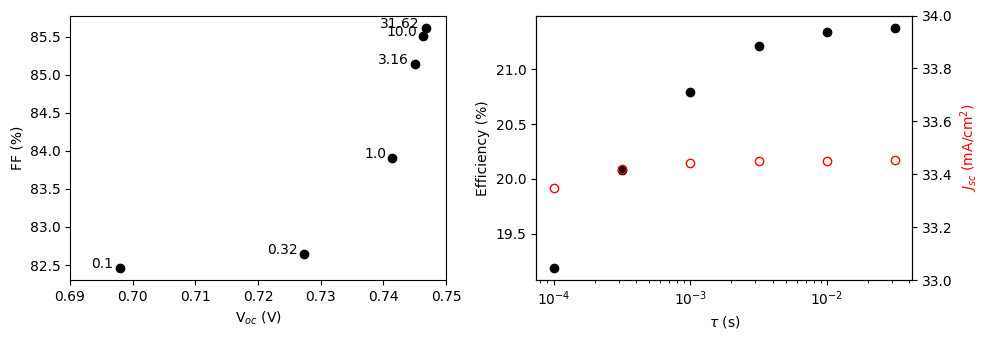

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))

ax1.plot(cell_results[:, 2], cell_results[:, 1], 'ko')

for i, lt in enumerate(lifetimes):
    ax1.annotate(str(np.round(1000*lt,2)), (cell_results[i, 2] - 0.001, cell_results[i, 1]), ha='right')

ax1.set_xlabel(r'V$_{oc}$ (V)')
ax1.set_ylabel('FF (%)')
ax1.set_xlim(0.69, 0.75)

ax2.semilogx(lifetimes, cell_results[:, 0], 'o', color='k')
ax2.set_ylabel('Efficiency (%)')
ax3 = ax2.twinx()
ax3.plot(lifetimes, cell_results[:, 3], 'o', color='r', markerfacecolor='none')
ax3.set_ylim(33, 34)
ax3.set_ylabel(r'$J_{sc}$ (mA/cm$^2$)', color='r')

ax2.set_xlabel(r'$\tau$ (s)')

plt.tight_layout()
plt.show()

As the lifetimes become very long, the fill factor shoots up rapidly, while the open-circuit voltage saturates. This increase in FF is faster than would be expected with an ideality factor of 1 (for SRH recombination) in the diode equation, and occurs because recombination becomes increasingly dominated by Auger recombination (ideality factor = 2/3). Compare the plot on the left with Figure 1b in [this paper](https://doi.org/10.1038/s41560-023-01255-2), where much the same behaviour is observed with data from real record efficiency devices.

## Other outputs from the PDD solver

Because we used a PDD solver, there are additional outputs in additional to the ones provided by all the junction models (open-circuit voltage, short-circuit current, efficiency, fill factor, etc.). Since solving the PDD equations requires calculating the distribution of carriers in the cell depending on the light and voltage biasing, we can access this information. Here, we will plot the energy levels of the conduction and valence band, and the electron and hole quasi-Fermi levels.

First, we find the index in the voltage array where the voltage is zero (i.e. short circuit), and the index where it is closest to the voltage at the maximum power point (Vmpp), which was calculated during the IV calculation earlier.

In [26]:
# index where voltage is zero:
SC_ind = np.argmin(np.abs(options.internal_voltages)) # index in voltage array where voltage is (closest to) zero: short circuit
MPP_ind = np.argmin(np.abs(options.internal_voltages - Si_cell.iv.Vmpp)) # index in voltage array where voltage is closest to Vmpp.

Now we get the conduction and valence band energy levels (Ec and Ev) and the electron and hole quasi-Fermi levels (Efe and Efh), at both of these voltages. The additional outpit from the PDD model are stored in each junction:

In [27]:
Ec_sc = Si_cell(0).pdd_output.Ec[SC_ind]
Ev_sc = Si_cell(0).pdd_output.Ev[SC_ind]

Efe_sc = Si_cell(0).pdd_output.Efe[SC_ind]
Efh_sc = Si_cell(0).pdd_output.Efh[SC_ind]

Ec_mpp = Si_cell(0).pdd_output.Ec[MPP_ind]
Ev_mpp = Si_cell(0).pdd_output.Ev[MPP_ind]

Efe_mpp = Si_cell(0).pdd_output.Efe[MPP_ind]
Efh_mpp = Si_cell(0).pdd_output.Efh[MPP_ind]

Now we plot thesince the cell is very wide, let's split the plot into two parts again, like we did for the doping, and plot the quantities we just extracted for at short circuit:

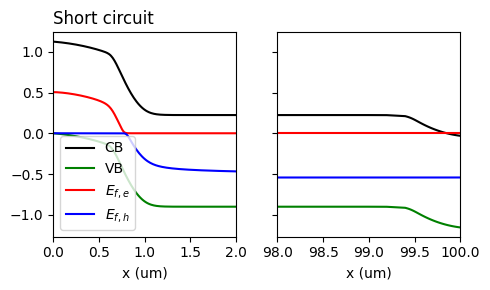

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(5, 3))
ax1.plot(Si_cell(0).mesh*1e6, Ec_sc, label='CB', color='k')
ax1.plot(Si_cell(0).mesh*1e6, Ev_sc, label='VB', color='g')
ax1.plot(Si_cell(0).mesh*1e6, Efe_sc, label=r'$E_{f, e}$', color='r')
ax1.plot(Si_cell(0).mesh*1e6, Efh_sc, label=r'$E_{f, h}$', color='b')

ax1.set_xlim(0, 2)
ax1.set_xlabel('x (um)')
ax1.legend()
ax1.set_title("Short circuit", loc='left')

ax2.plot(Si_cell(0).mesh*1e6, Ec_sc, label='CB', color='k')
ax2.plot(Si_cell(0).mesh*1e6, Ev_sc, label='VB', color='g')
ax2.plot(Si_cell(0).mesh*1e6, Efe_sc, label=r'$E_{f, e}$', color='r')
ax2.plot(Si_cell(0).mesh*1e6, Efh_sc, label=r'$E_{f, h}$', color='b')

ax2.set_xlim(d_bulk*1e6 - 2, d_bulk*1e6)
ax2.set_xlabel('x (um)')
plt.tight_layout()
plt.show()

And at the maximum power point:

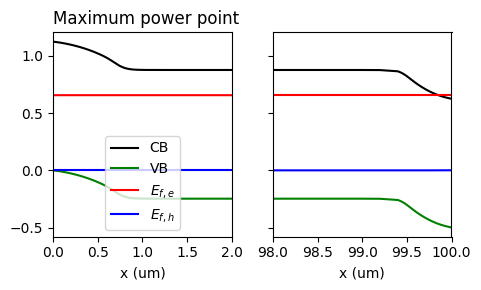

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(5, 3))

ax1.plot(Si_cell(0).mesh*1e6, Ec_mpp, label='CB', color='k')
ax1.plot(Si_cell(0).mesh*1e6, Ev_mpp, label='VB', color='g')
ax1.plot(Si_cell(0).mesh*1e6, Efe_mpp, label=r'$E_{f, e}$', color='r')
ax1.plot(Si_cell(0).mesh*1e6, Efh_mpp, label=r'$E_{f, h}$', color='b')
ax1.set_xlim(0, 2)
ax1.set_xlabel('x (um)')
ax1.legend()
ax1.set_title("Maximum power point", loc='left')

ax2.plot(Si_cell(0).mesh*1e6, Ec_mpp, label='CB', color='k')
ax2.plot(Si_cell(0).mesh*1e6, Ev_mpp, label='VB', color='g')
ax2.plot(Si_cell(0).mesh*1e6, Efe_mpp, label=r'$E_{f, e}$', color='r')
ax2.plot(Si_cell(0).mesh*1e6, Efh_mpp, label=r'$E_{f, h}$', color='b')

ax2.set_xlim(d_bulk*1e6 - 2, d_bulk*1e6)
ax2.set_xlabel('x (um)')
plt.tight_layout()
plt.show()

As expected, we see that at forward bias, the band-bending is reduced. We also see that at the rear, where the cell is very highly doped, the electron quasi-Fermi level is inside the conduction band.

## Questions

- What are some of the pros and cons of using the depletion approximation vs. the drift-diffusion solver?


## Exercise

Have a look at the [list of quantities](http://docs.solcore.solar/en/latest/Solvers/SesameDDsolver.html) which are contained in the ``pdd_output`` attribute of the Si junction,
and try to produce plots like the ones above (or at any other voltage you are interested in) of the electron and hole densities as a function of position in the junction.